In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
%matplotlib inline

In [2]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [3]:
data[data['goal'] < 5]['success_rate'].mean()

331540.3557309402

<AxesSubplot:>

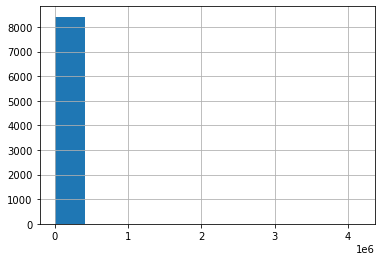

In [4]:
data['success_rate'].hist(bins=10)

In [5]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [6]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [21]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [22]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [23]:
def draw_hist(df, features, var_labels, bar_type=None, n_bins=10):
    bar_type = 'bar' if bar_type == None else bar_type
    for col in features:
        plt.figure(figsize=(14, 10))
        plt.hist(df[col], histtype=bar_type, bins=n_bins, color='#BF2D00')
        plt.xlabel(var_labels[col], size=20)
        plt.ylabel(f'Количество проектов', size=20)

In [24]:
def draw_scatter(df, col):
    plt.figure(figsize=(14, 10))
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'], c='#BF2D00')
    plt.xlabel(f'Значение переменной {col}, в ед.', fontsize=20)
    plt.ylabel(f'Значение success_rate, в %.', fontsize=20)

In [25]:
def del_n_sigmas_emissions(df, col_name, n_sigmas=3) -> DataFrame:
    len_was = df.shape[0]
    std = df[col_name].std()
    mean = df[col_name].mean()
    result = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
    print(f'{col_name}: {len_was - result.shape[0]} lines deleted')
    return result    

Shape was: 8421
created: 179 lines deleted
n_pled_t: 91 lines deleted
goal: 67 lines deleted
period: 43 lines deleted
goal < 15: 26
success_rate: 84 lines deleted
mgp: 138 lines deleted
n_img: 101 lines deleted


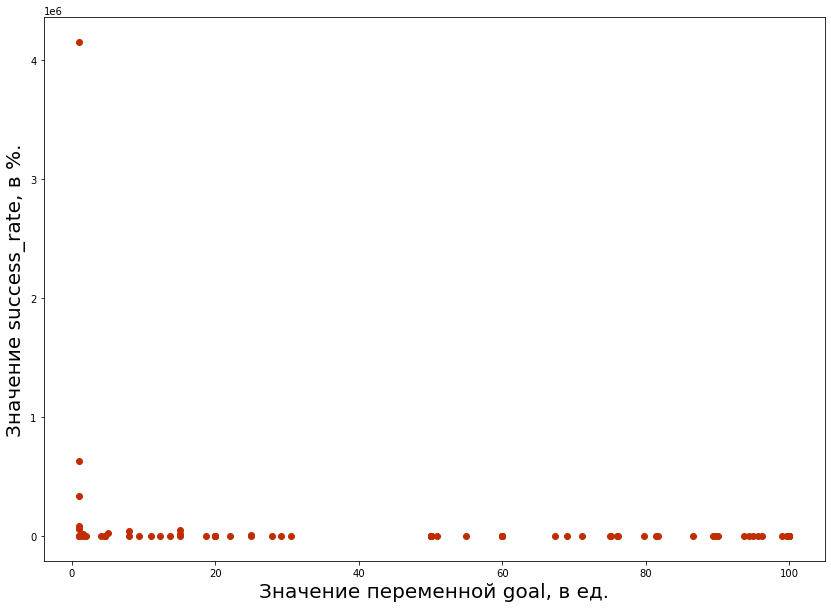

In [26]:
# Remove emissions
df = data.copy()
df['site'].fillna('', inplace=True)

print(f'Shape was: {df.shape[0]}')
# Using 3 sigmas rule
df = del_n_sigmas_emissions(df, 'created')
df = del_n_sigmas_emissions(df, 'n_pled_t')
df = del_n_sigmas_emissions(df, 'goal') # Probably remove < 5.0 projects too
df = del_n_sigmas_emissions(df, 'period')
draw_scatter(df.sort_values(by=['goal']).iloc[0:df.shape[0] // 100], 'goal')
len_was = df.shape[0]
df = df[df['goal'] > 15]
print('goal < 15:', len_was - df.shape[0])
df = del_n_sigmas_emissions(df, 'success_rate')
df = del_n_sigmas_emissions(df, 'mgp')
df = del_n_sigmas_emissions(df, 'n_img')

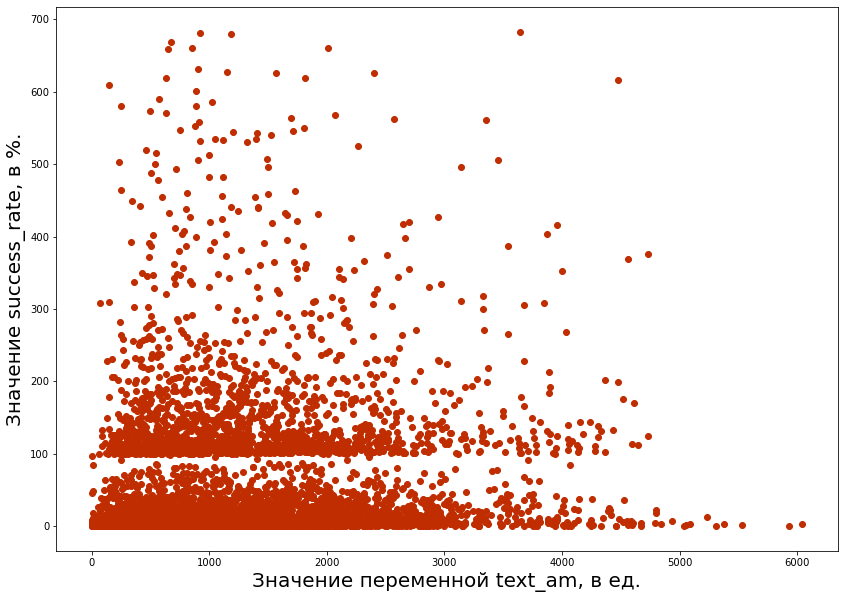

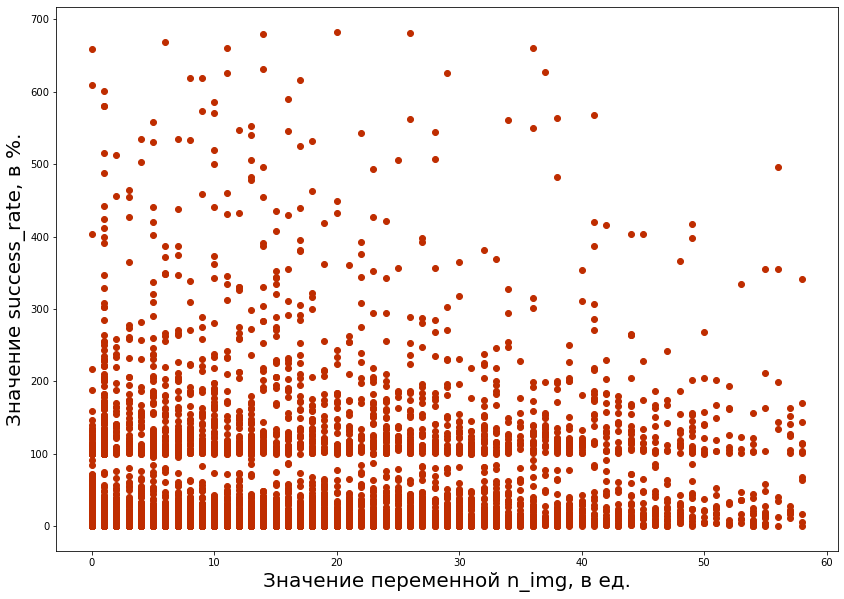

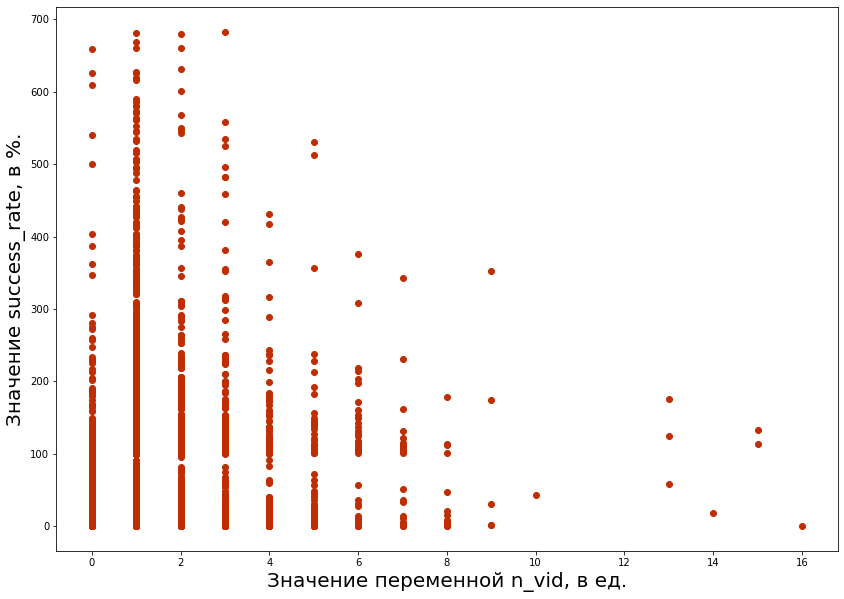

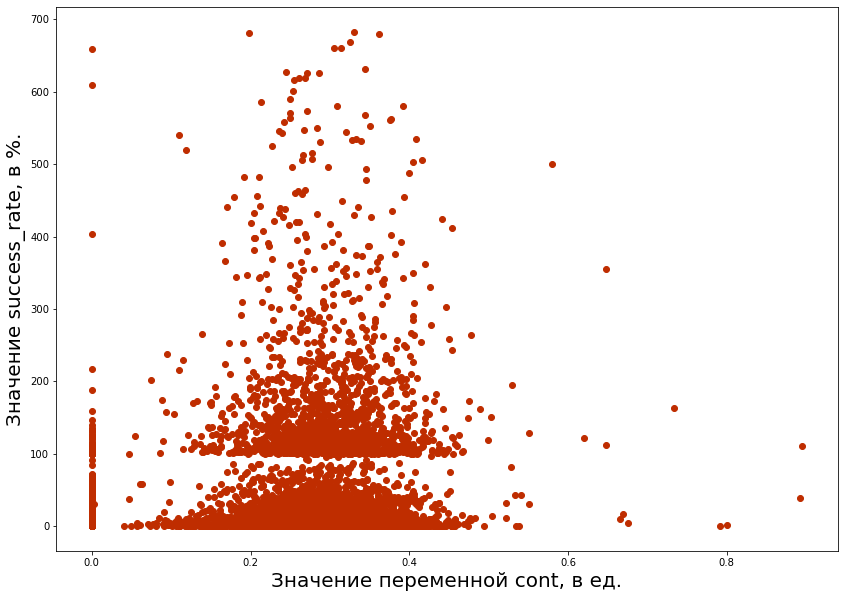

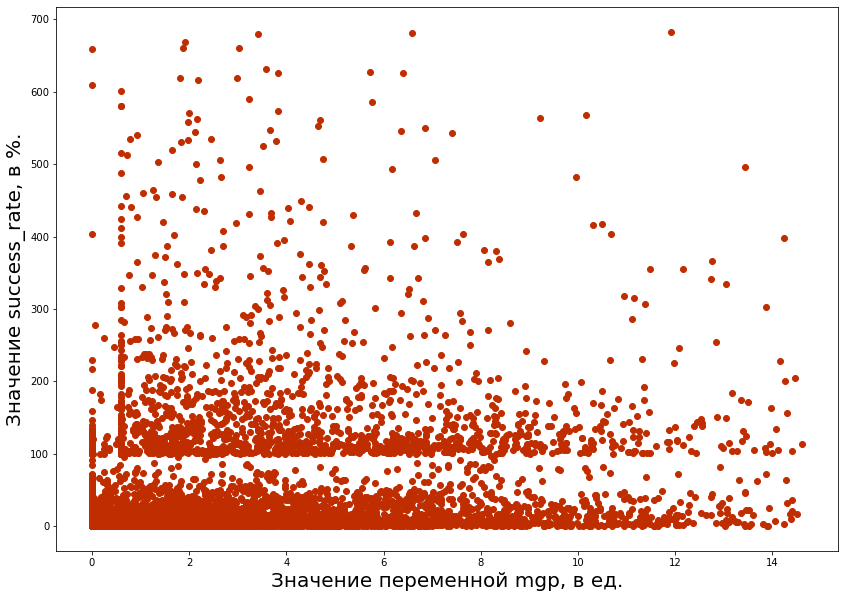

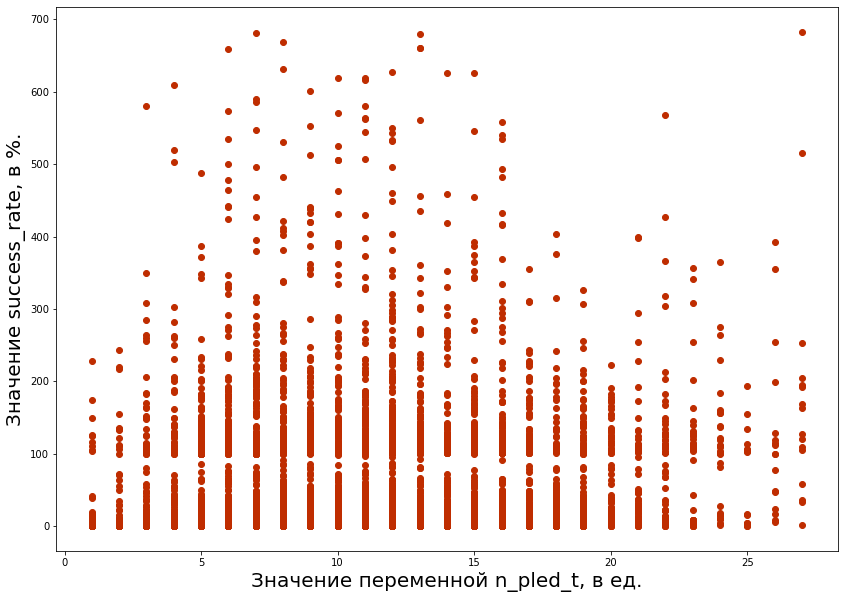

In [27]:
for col in futures:
    draw_scatter(df, col)

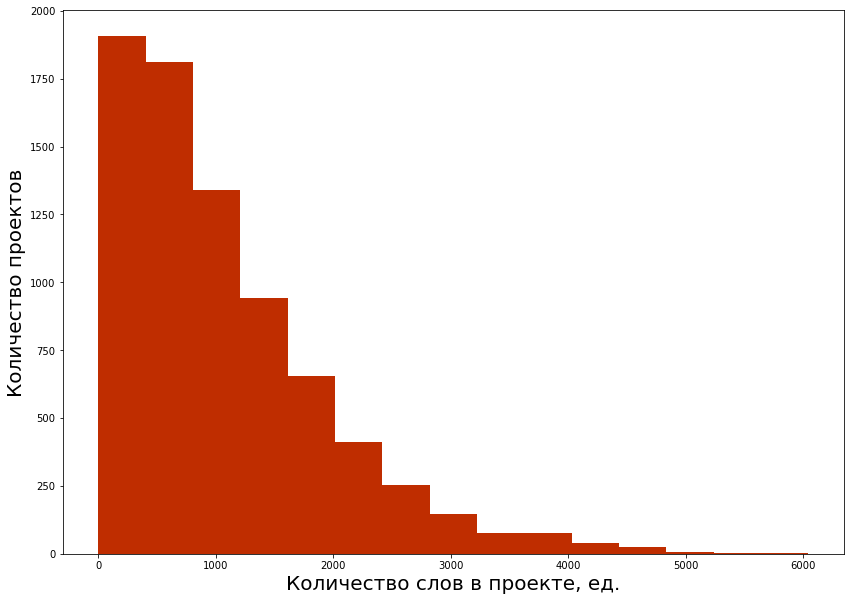

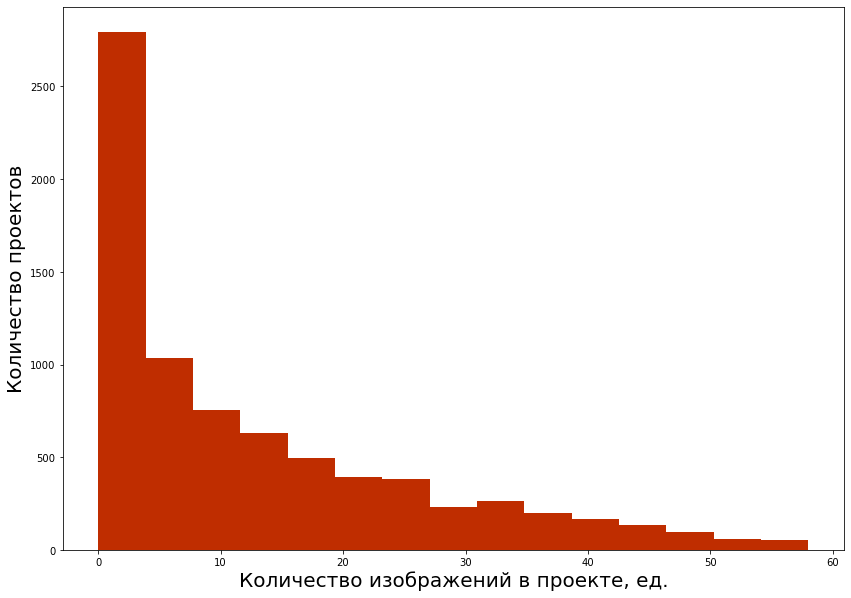

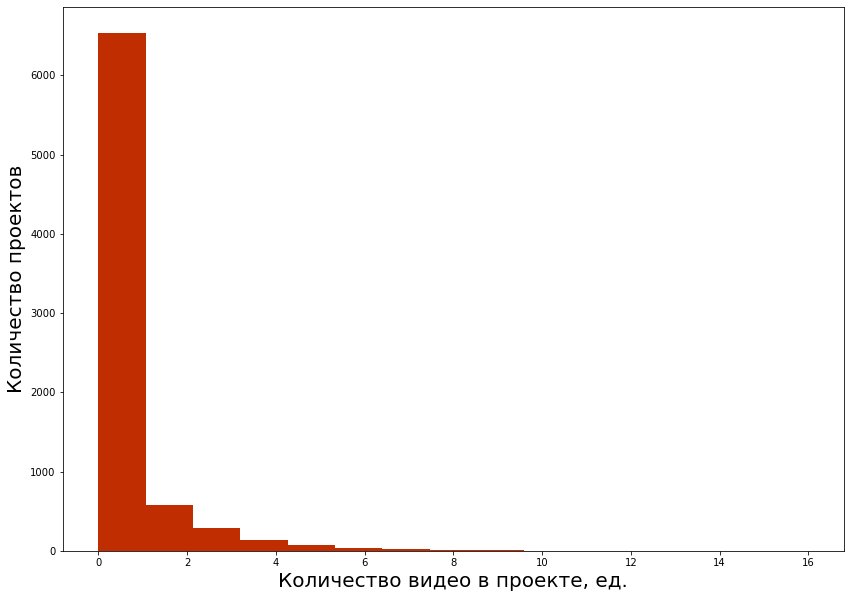

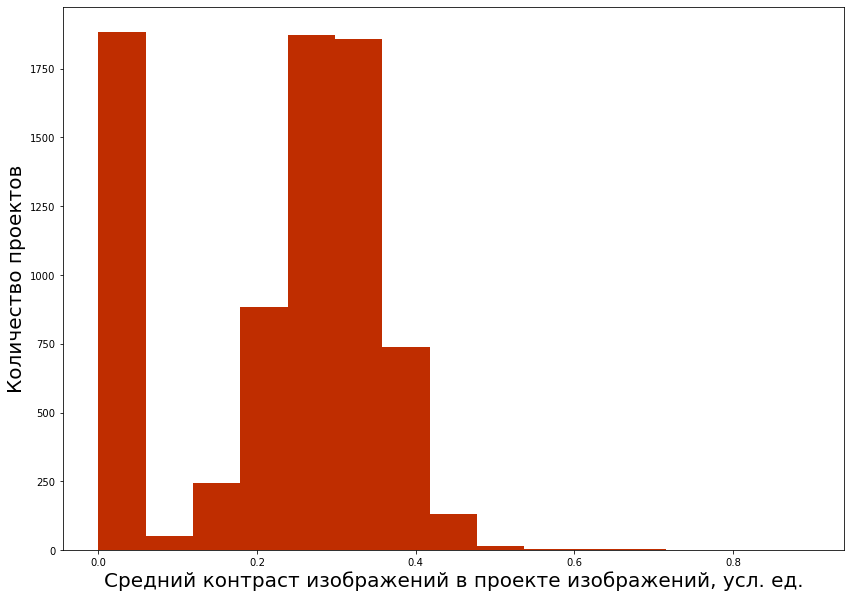

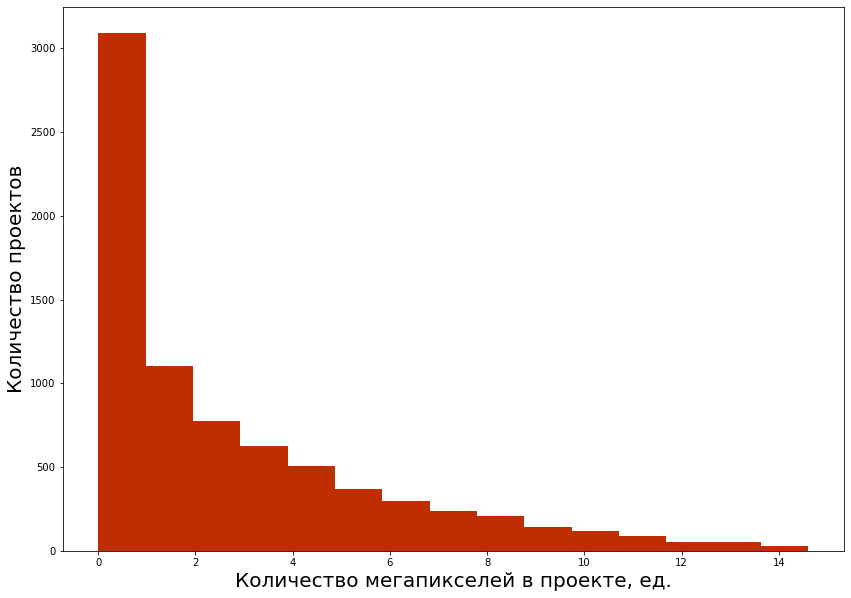

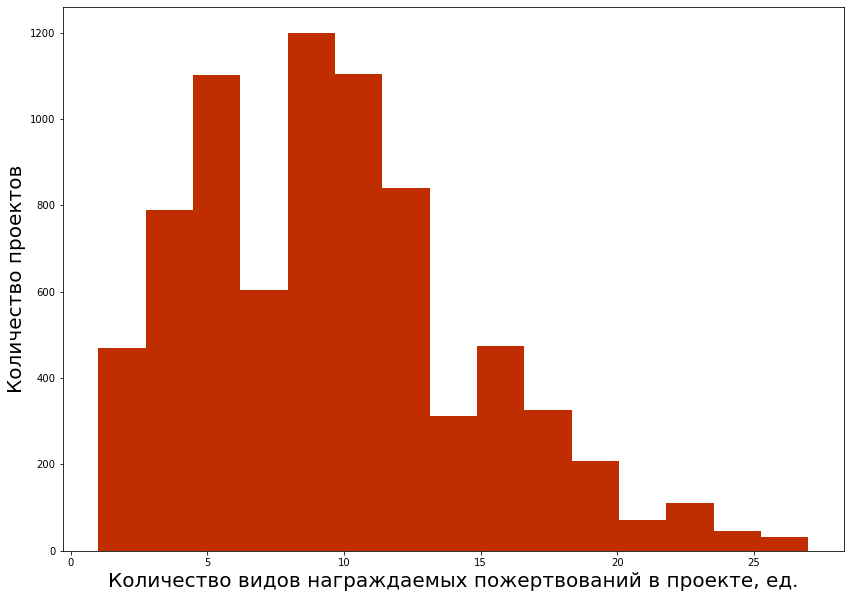

In [28]:
draw_hist(df, futures, {
    'n_img': 'Количество изображений в проекте, ед.',
    'n_vid': 'Количество видео в проекте, ед.',
    'n_pled_t': 'Количество видов награждаемых пожертвований в проекте, ед.',
    'cont': 'Средний контраст изображений в проекте изображений, усл. ед.',
    'mgp': 'Количество мегапикселей в проекте, ед.',
    'text_am': 'Количество слов в проекте, ед.',
    'period': 'Длительность периода сбора средств, дн.'}, n_bins=15)

In [29]:
# Descriptive statistics
desc = df[futures].describe()
desc.loc[:'count'] = desc.loc[:'count'].astype(np.int64)
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_img,n_vid,cont,mgp,n_pled_t
count,7692.000000,7692.000000,7692.000000,7692.000000,7692.000000,7692.000000
mean,1072.533151,12.488430,0.683307,0.221325,2.721997,9.544722
std,868.286309,13.723394,1.249966,0.139719,3.103777,5.136894
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,405.000000,1.000000,0.000000,0.110672,0.082772,6.000000
50%,837.000000,8.000000,0.000000,0.266677,1.623755,9.000000
75%,1503.000000,20.000000,1.000000,0.321789,4.205560,13.000000
max,6042.000000,58.000000,16.000000,0.894847,14.609122,27.000000


In [30]:
pd.DataFrame(df.corr()['success_rate'][futures])

,success_rate
text_am,0.203623
n_img,0.225704
n_vid,0.331069
cont,0.237223
mgp,0.238702
n_pled_t,0.216174


In [31]:
def draw_dependencies(df, features):
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            col = features[cols * i + j]
            xs = []
            ys = []

            if col == 'text_am':
                n_texts = []
                step = 200
                for v in range(1, df['text_am'].max(), step):
                    s = df[(df['text_am'] >= v) & (df['text_am'] < v + step)]['success_rate']
                    if s.shape[0] > 5: 
                        n_texts.append((f'{int((2 * v + step) / 2)}', v, s.sum() / s.shape[0]))

                n_texts = sorted(n_texts, key=lambda x: x[1])

                xs = [k for title, k, v in n_texts]
                ys = [v for title, k, v in n_texts]
            elif col == 'cont':
                n_conts = []
                step = 0.05
                for v in np.arange(0, df['cont'].max(), step):
                    s = df[(df['cont'] >= v) & (df['cont'] < v + step)]['cont']
                    if s.shape[0] > 2: 
                        n_conts.append((f'{(2 * v + step) / 2}', v, s.sum() / s.shape[0]))

                n_conts = sorted(n_conts, key=lambda x: x[1])

                xs = [k for title, k, v in n_conts]
                ys = [v for title, k, v in n_conts]
            else:
                for val in sorted(df[col].unique()):
                    mean_sr = df[df[col] == val]['success_rate'].mean()
                    if df[df[col] == val].shape[0] > 5:
                        xs.append(val)
                        ys.append(mean_sr)

            axes[i, j].plot(xs, ys)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Значение переменной success_rate', size=14)

In [32]:
def split_array_by_parts(array_len, n_splits):
    """
    Returns indices for split parts
    """
    step = 0
    if array_len % n_splits == 0:
        step = array_len // n_splits
    else:
        step = array_len // n_splits + 1
    i = 0
    result = []
    while i < array_len:
        result.append((i, min(i + step, array_len)))
        i += step
    return result


def draw_dep(df, cols, n_intervals, var_labels):
    step = 1.0 / n_intervals
    
    indices = split_array_by_parts(df.shape[0], n_intervals)
    
    for col in cols:
        plt.figure(figsize=(14, 10))
        plot_vals = {}
        repeats = {}
        xs = []
        ys = []

        sorted_df = df.sort_values(by=[col])
        for start, stop in indices:
            cur_vals = sorted_df.iloc[start : stop]
            col_median = cur_vals[col].median()
            s_r_mean = cur_vals['success_rate'].mean()

            xs.append(col_median)
            ys.append(s_r_mean)
        if col == 'text_am':
            print(xs)
        new_xs, new_ys = [], []
        reps = {}
        vals = {}
        for x, y in zip(xs, ys):
            if x not in reps:
                reps[x] = 0
                vals[x] = []
            reps[x] += 1
            vals[x].append(y)
        for x, n_reps in reps.items():
            new_ys.append(sum(vals[x]) / n_reps)
            es = 0
            if col == 'text_am':
                x /= 100
            new_xs.append(float(f'{x:.2f}'))


        plt.bar(new_xs, new_ys, color='#BF2D00')
        plt.xlabel(var_labels[col], fontsize=20)
        plt.ylabel(f'Среднее отношение собраных средств к цели, в %.', fontsize=20)            

[73.0, 125.0, 164.0, 195.0, 229.0, 261.0, 294.0, 324.0, 356.0, 391.0, 426.0, 465.0, 504.0, 551.0, 591.0, 632.0, 677.0, 725.0, 768.0, 816.0, 870.0, 924.0, 983.0, 1043.0, 1101.0, 1162.0, 1232.0, 1310.0, 1382.0, 1470.0, 1561.0, 1654.0, 1752.0, 1878.0, 2017.0, 2175.0, 2398.0, 2652.0, 3068.0, 3961.0]


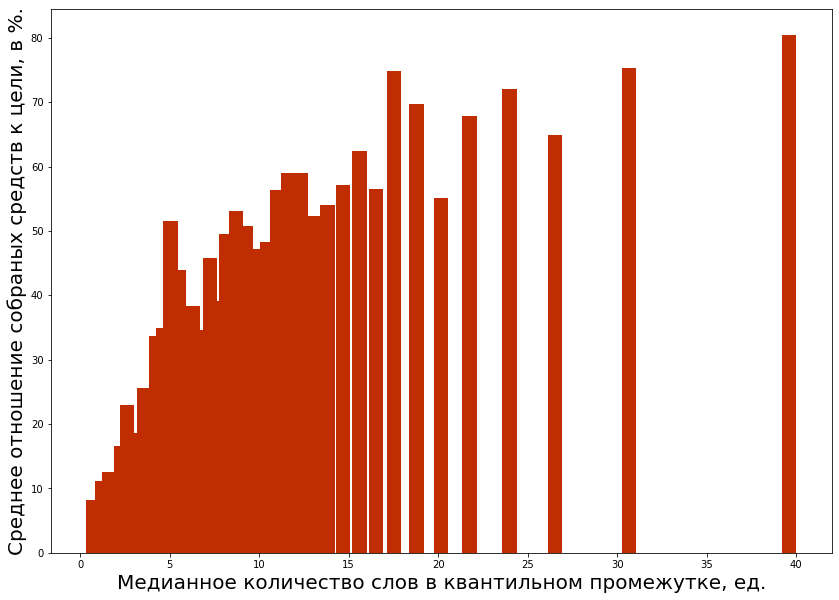

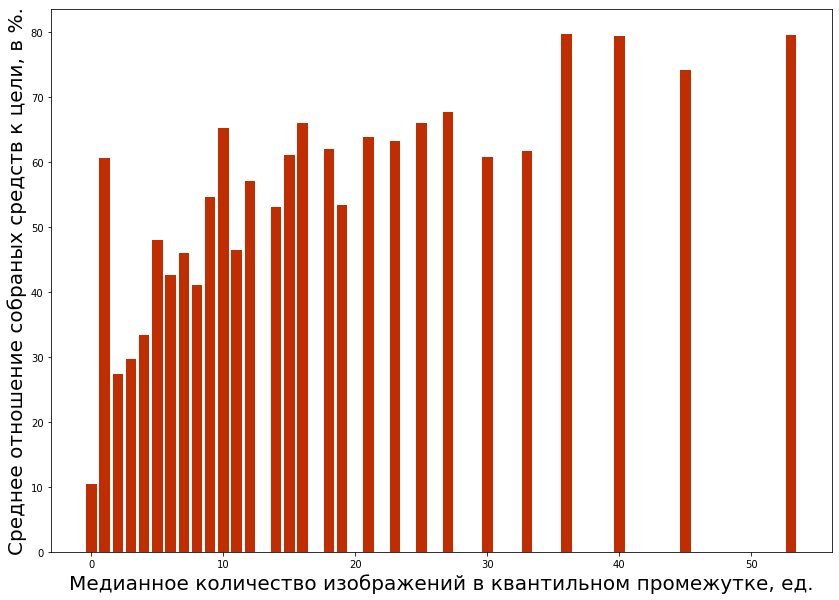

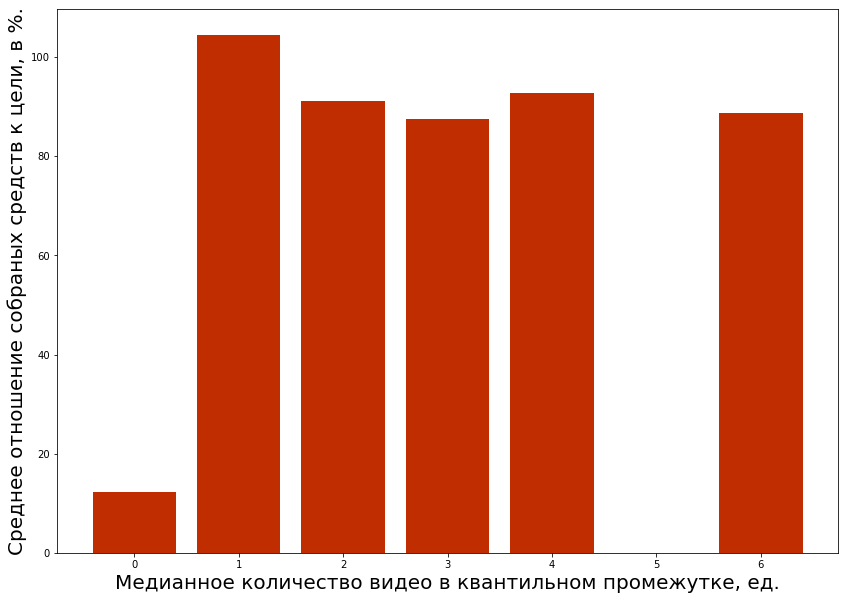

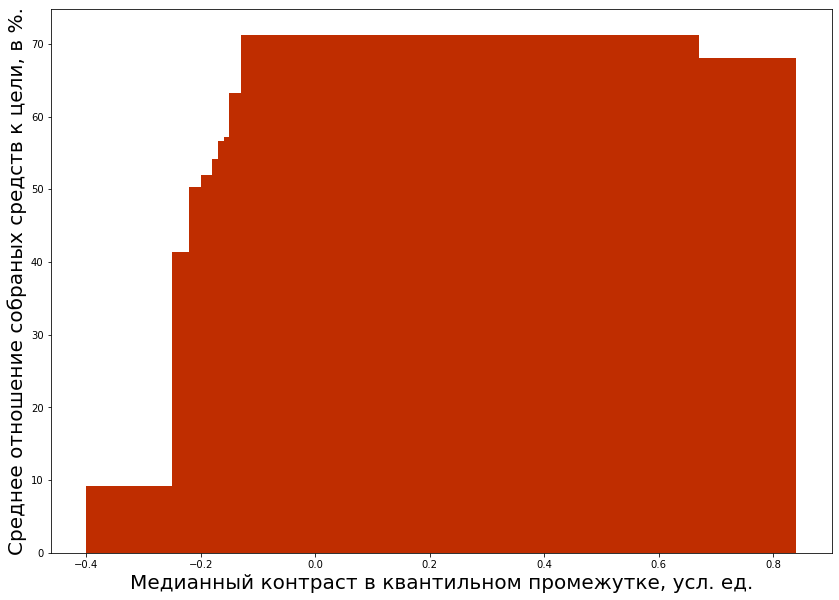

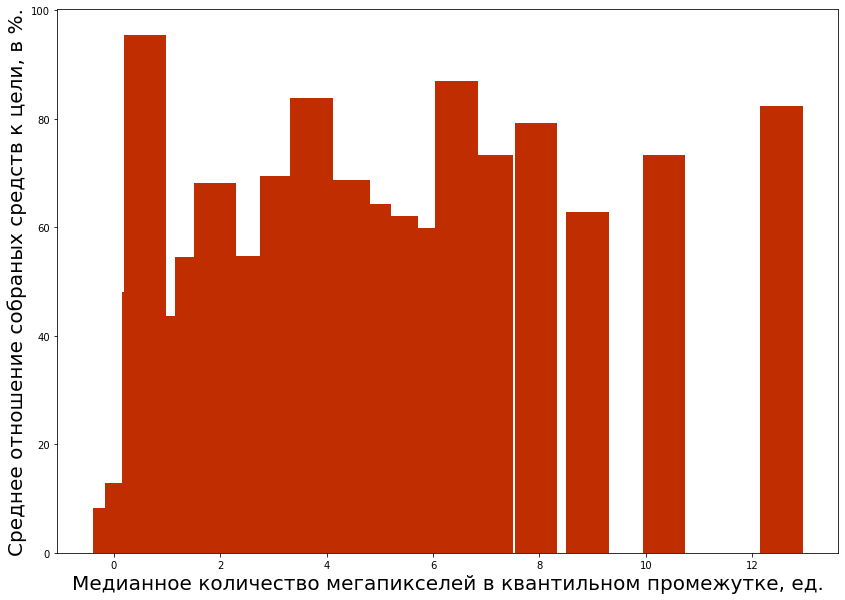

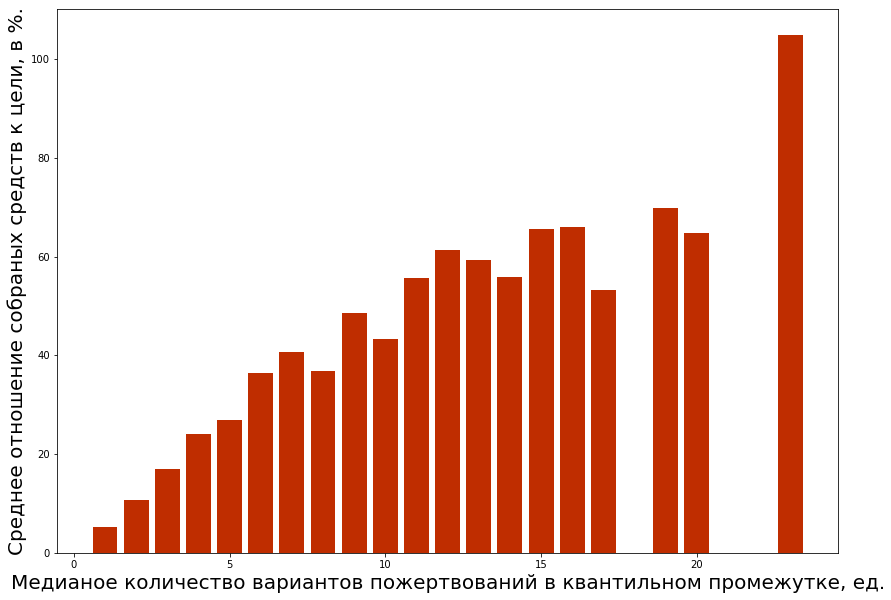

In [33]:
# draw_dependencies(df, futures)
draw_dep(df, futures, 40,
        {'n_img': 'Медианное количество изображений в квантильном промежутке, ед.',
         'n_vid': 'Медианное количество видео в квантильном промежутке, ед.',
         'mgp': 'Медианное количество мегапикселей в квантильном промежутке, ед.',
         'cont': 'Медианный контраст в квантильном промежутке, усл. ед.',
         'n_pled_t': 'Медианое количество вариантов пожертвований в квантильном промежутке, ед.',
         'text_am': 'Медианное количество слов в квантильном промежутке, ед.'})

(8421, 39)


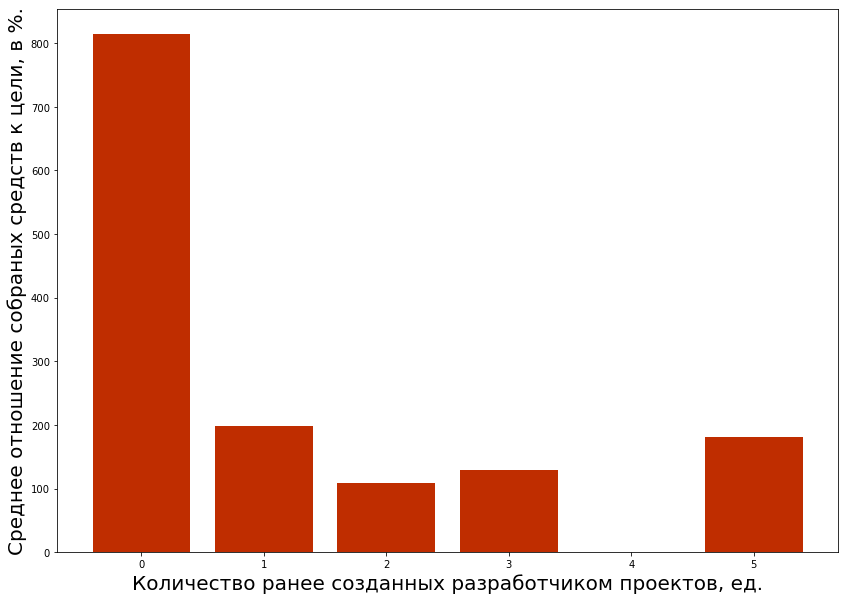

In [34]:
print(data.shape)
draw_dep(data, ['created'], 60, {'created': 'Количество ранее созданных разработчиком проектов, ед.'})

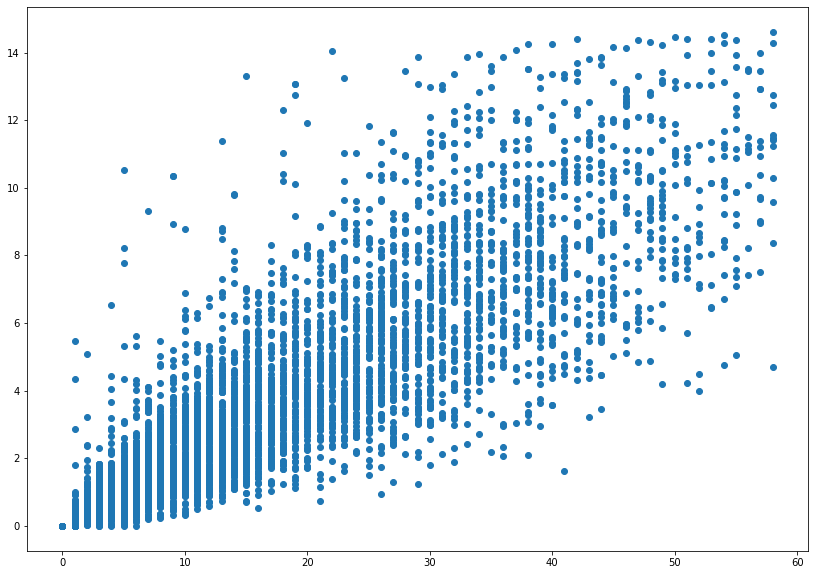

In [35]:
plt.figure(figsize=(14, 10))
plt.scatter(df['n_img'], df['mgp'])

In [51]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [37]:
numeric_columns = [
#   'pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
columns = numeric_columns + binary_columns

In [38]:
print(df[df['success_rate']== 0])

      Unnamed: 0                                                URL  pled  \
11          8067  https://www.kickstarter.com/projects/956066601...   0.0   
63          1488  https://www.kickstarter.com/projects/146790603...   0.0   
105         1698  https://www.kickstarter.com/projects/185280927...   0.0   
123         2118  https://www.kickstarter.com/projects/polygonwo...   0.0   
130         5574  https://www.kickstarter.com/projects/150502051...   0.0   
...          ...                                                ...   ...   
8291        8467  https://www.kickstarter.com/projects/123108330...   0.0   
8345        1016  https://www.kickstarter.com/projects/xiiihell/...   0.0   
8391        2257  https://www.kickstarter.com/projects/wind0wned...   0.0   
8393        2132  https://www.kickstarter.com/projects/173627180...   0.0   
8394        8158  https://www.kickstarter.com/projects/470779507...   0.0   

           goal        date  period status  text_am  n_img  n_vid  ...  ind

In [57]:
inp = df[columns]  # .assign(bias=np.ones((df.shape[0])))
# square_columns = []
# for col in futures:
#     inp[f'{col}_sqr'] = inp[col] ** 2
#     square_columns.append(f'{col}_sqr')

ols = sm.OLS(df['success_rate'], inp)
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           success_rate   R-squared (uncentered):                   0.368
Model:                            OLS   Adj. R-squared (uncentered):              0.365
Method:                 Least Squares   F-statistic:                              148.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                        0.00
Time:                        17:13:09   Log-Likelihood:                         -44102.
No. Observations:                7692   AIC:                                  8.826e+04
Df Residuals:                    7662   BIC:                                  8.847e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
goal           -0.0001   1.16e-05     -8.851      0.000      -0.000   -8.01e-05
period         -0.1276      0.054     -2.376      0.018      -0.233      -0.022
text_am         0.0048      0.001      3.277      0.001       0.002       0.008
n_img          -0.4999      0.151     -3.307      0.001      -0.796      -0.204
n_vid          16.7737      0.760     22.075      0.000      15.284      18.263
n_pled_t        1.8419      0.249      7.411      0.000       1.355       2.329
min_pled_t      0.0058      0.007      0.880      0.379      -0.007       0.019
max_pled_t     -0.0024      0.001     -3.377      0.001      -0.004      -0.001
mean_pled_t    -0.0015      0.005     -0.291      0.771      -0.011       0.008
step_pled_t     0.0053      0.005      1.156      0.248      -0.004       0.014
cr_time         0.0042      0.002      1.694      0.090      -0.001       0.009
backed          0.2562      0.089      2.883      0.004       0.082       0.430
created         7.9493      2.022      3.932      0.000       3.986      11.912
mgp             2.8883      0.616      4.689      0.000       1.681       4.096
cont           67.1570      6.831      9.831      0.000      53.766      80.548
rpg            11.6833      2.218      5.268      0.000       7.336      16.031
platformer     -4.1608      3.393     -1.226      0.220     -10.812       2.491
shooter       -11.1641      3.027     -3.688      0.000     -17.098      -5.230
fighting       -3.8311      2.672     -1.434      0.152      -9.070       1.407
survival       -4.5566      2.794     -1.631      0.103     -10.033       0.919
horror         -7.1957      3.466     -2.076      0.038     -13.990      -0.401
strategy       -6.3146      2.532     -2.494      0.013     -11.278      -1.351
arcade          5.6521      3.079      1.836      0.066      -0.383      11.687
simulator      -6.6866      4.743     -1.410      0.159     -15.983       2.610
mmo           -11.9401      3.575     -3.340      0.001     -18.948      -4.933
indie           7.1861      2.152      3.340      0.001       2.968      11.404
action         -9.9914      2.107     -4.741      0.000     -14.122      -5.860
quest           2.7537      2.813      0.979      0.328      -2.760       8.267
adventure       3.3124      2.124      1.560      0.119      -0.851       7.476
is_site         7.2001      1.972      3.650      0.000       3.334      11.066
==============================================================================
Omnibus:                     5534.676   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           105669.257
Skew:                           3.282   Prob(JB):                         0.00
Kurtosis:                   

In [58]:
def draw_lines_on_plot(df, col, coeffs, bias):
    plt.figure(figsize=(14, 10))
    def func(x):
        res = bias
        for i in range(len(coeffs)):
            res += coeffs[i] * x ** (len(coeffs) - i)
        return res
    plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), c='red')
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'])

In [41]:
# for col in ['n_img', 'n_vid', 'mgp', 'cont', 'n_pled_t']:
#     draw_lines_on_plot(inp.assign(success_rate=df['success_rate']),
#                        col, [summary_df['coef'][f'{col}_sqr'], summary_df['coef'][col]], summary_df['coef']['bias'])

In [64]:
# Cascade Adj. r^2 check
inp = df[columns].assign(bias=np.ones((df.shape[0])))
ols = sm.OLS(df['success_rate'], inp)
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

r_2_origin = res.rsquared_adj

important_cols = list(summary_df.index)

for col in summary_df.index:
    col_copy = inp[col]
    inp = inp.drop(columns=[col])
    ols = sm.OLS(df['success_rate'], inp)
    res = ols.fit()
    new_r_2 = res.rsquared_adj
    
    if (new_r_2 - r_2_origin) / r_2_origin < -0.001:
            inp[col] = col_copy
    else:
        print('removed', col, (new_r_2 - r_2_origin) / r_2_origin)
        important_cols.remove(col)
print(important_cols)

removed min_pled_t 0.00020800381153847423
removed mean_pled_t 0.0007456452935390593
removed step_pled_t 0.0009504903795125965
removed cr_time 0.00016468905651914053
removed platformer -0.00021115595536031178
removed fighting -0.0008846782200259773
removed quest -0.0008582153989315546
removed bias 1.0050601346191594
['goal', 'period', 'text_am', 'n_img', 'n_vid', 'n_pled_t', 'max_pled_t', 'backed', 'created', 'mgp', 'cont', 'rpg', 'shooter', 'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'adventure', 'is_site']
